In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the Google drive if needed

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralDDE_ROM_Closure'))

### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
import src.solvers.neuralDistDDE_with_adjoint as nddde
import src.advec_diff_case.advec_diff_eqn as adeq
import src.advec_diff_case.rom_advec_diff as rom

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from shutil import move
import pickle

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

## Define some useful classes

### Class for user-defined arguments

In [4]:
class rom_ad_eq_nDistDDE_args(nddde.nddde_arguments, rom.rom_eqn_args):

    def __init__(self, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.05, decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                 d_max = 1., nn_d1 = 0., nn_d2 = 0.5, state_dim = 2, adj_data_size = 2,
                 model_dir = 'ROM_nDistDDE_testcase/model_dir_test', restart = 0, val_percentage = 0.2,
                 T = 2., nt = 200, L = 1., nx = 100, Re = 250, u_bc_0 = 0., u_bc_L =0., rom_dims = 2, isplot = True, reg_coeff = 0.001): # add more arguments as needed
        
        nddde.nddde_arguments.__init__(self, data_size = nt, batch_time = batch_time, batch_time_skip = batch_time_skip, batch_size = batch_size, epochs = epochs,
                           learning_rate = learning_rate, decay_rate = decay_rate, test_freq = test_freq, plot_freq = plot_freq, d_max = d_max, nn_d1 = nn_d1, 
                           nn_d2 = nn_d2, state_dim = rom_dims, adj_data_size = rom_dims, model_dir = model_dir, restart = restart, val_percentage = val_percentage, isplot = isplot)

        rom.rom_eqn_args.__init__(self, T = T, nt = nt, L = L, nx = nx, Re = Re, u_bc_0 = u_bc_0, u_bc_L = u_bc_L, rom_dims = rom_dims, 
                              rom_batch_size = batch_size, ad_eq_batch_size = 1)
        
        self.rom_args_for_plot = rom.rom_eqn_args(T = T, nt = nt, L = L, nx = nx, Re = Re, u_bc_0 = u_bc_0, u_bc_L = u_bc_L, rom_dims = rom_dims, 
                              rom_batch_size = 1, ad_eq_batch_size = 1)
        
        self.reg_coeff = reg_coeff

### Define the neural net architecture

In [5]:
class create_mean_modes:
    def __init__(self, fom_sol, app, t):
        self.fom_sol = fom_sol
        self.app = app
        self.t = t

    def __call__(self):

        u_analy = tf.transpose(self.fom_sol)

        u_mean = tf.expand_dims(tf.reduce_mean(u_analy, axis=-1), axis=1)

        S, U, V = tf.linalg.svd(u_analy - tf.tile(u_mean, [1, len(self.t)]))

        ui = U[:, 0:self.app.rom_dims]

        return u_mean, ui

### Define a custom loss function

### Define a custom plotting function

In [6]:
class custom_plot:

    def __init__(self, true_y, y_no_nn, t, args):
        self.true_y = true_y
        self.y_no_nn = y_no_nn
        self.t = t
        self.args = args
        self.colors = ['b', 'g', 'r', 'k', 'c', 'm']

    def plot(self, *pred_y):
        fig = plt.figure(figsize=(6, 4), facecolor='white')
        ax = fig.add_subplot(111)

        ax.cla()
        ax.set_title('Coefficients', fontsize=14)
        ax.set_xlabel('t', fontsize=14)
        ax.set_ylabel('$a_i$', fontsize=14)
        ax.set_xlim(min(self.t.numpy()), max(self.t.numpy()))
        ax.set_ylim(-1, 1.1)

        for i in range(self.args.rom_dims):
            ax.plot(self.t.numpy(), self.true_y.numpy()[:, 0, i], self.colors[i % self.args.rom_dims]+'-', label = 'True Coeff. '+str(i+1))
            ax.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, i], self.colors[i % self.args.rom_dims]+'-.', label = 'POD-GP Coeff. '+str(i+1))
            ax.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, i], self.colors[i % self.args.rom_dims]+'--', label = 'Learned Coeff. '+str(i+1))

        ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.show() 

### Initial Conditions

In [7]:
class initial_cond:

    def __init__(self, x, app):
        self.x = x
        self.app = app

    def __call__(self, t):
        u0 = self.x / (1. + np.sqrt(1./self.app.t0) * np.exp(self.app.Re * self.x**2 / 4., dtype = np.float64))
        return tf.convert_to_tensor([u0], dtype=tf.float32)

In [8]:
class red_initial_cond:
    
    def __init__(self, ai_t0, u_mean, u_modes):
        self.ai_t0 = ai_t0
        self.u_mean = u_mean
        self.u_modes = u_modes
        
    def __call__(self, t):

        u0_rom = tf.transpose(self.u_mean, perm=[1, 0])             + tf.cast(tf.einsum('ab, db -> da', tf.cast(self.u_modes, tf.float64), tf.cast(self.ai_t0(t), tf.float64)), tf.float32)
        
        return u0_rom

### Initialize model related parameters

In [9]:
args = rom_ad_eq_nDistDDE_args(batch_time = 6, batch_time_skip = 2, batch_size = 2, epochs = 500, learning_rate = 0.075, decay_rate = 0.97, test_freq = 1, plot_freq = 2,
                    d_max = 0.2, nn_d1 = 0., nn_d2 = 0.175, model_dir = 'ROM_nDistDDE_testcase/model_dir_case49', restart = 0, val_percentage = 1.,
                    T = 1.25, nt = 125, L = 1., nx = 100, Re = 1000, u_bc_0 = 0., u_bc_L =0., rom_dims = 3, reg_coeff = 0.)

### Copy the NN architecture from the save directory

In [10]:
class DDEFuncMain(tf.keras.Model):

    def __init__(self, **kwargs):
        super(DDEFuncMain, self).__init__(**kwargs)
        
        self.x1 = tf.keras.layers.Dense(5, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.x2 = tf.keras.layers.Dense(5, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.out = tf.keras.layers.Dense(args.state_dim, activation='linear',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)

    def call(self, z):
        for i in range(len(self.layers)):
            z = self.layers[i](z)
        return z

In [11]:
class DDEFuncAux(tf.keras.Model):

    def __init__(self, **kwargs):
        super(DDEFuncAux, self).__init__(**kwargs)
        
        self.x1 = tf.keras.layers.Dense(3, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.x2 = tf.keras.layers.Dense(3, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)

        self.out = tf.keras.layers.Dense(2, activation='linear',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)

    def call(self, z):
        for i in range(len(self.layers)):
            z = self.layers[i](z)
        return z

In [12]:
class split_zy:
    def __init__(self, zy, args):
        self.zy = zy
        self.args = args

    def __call__(self, t):
        return self.zy(t)[:, :self.args.state_dim]

In [13]:
class DistDDEFunc:

    def __init__(self, main, aux, rom_model, args):
        self.main = main
        self.aux = aux
        self.rom_model = rom_model
        self.args = args

    def __call__(self, y, t ,d):
        
        get_z = split_zy(y, self.args)

        dz_dt = self.main(y(t)) + self.rom_model(get_z, t) + args.reg_coeff * tf.random.normal([y(t).shape[0], args.state_dim])
        gz_t1 = self.aux(y(t - d[0])[:, :self.args.state_dim])
        gz_t2 = self.aux(y(t - d[1])[:, :self.args.state_dim])
        dy_dt = gz_t1 - gz_t2
        return tf.concat([dz_dt, dy_dt], axis=-1)

In [14]:
os.chdir(basedir)

checkpoint_dir_main = os.path.join(args.model_dir, "ckpt_main")
checkpoint_dir_aux = os.path.join(args.model_dir, "ckpt_aux")
checkpoint_prefix_main = os.path.join(checkpoint_dir_main, "cp-{epoch:04d}.ckpt")
checkpoint_prefix_aux = os.path.join(checkpoint_dir_aux, "cp-{epoch:04d}.ckpt")

### Solve for the high resolution model

In [15]:
x = tf.linspace(0., args.L, args.nx)
t = tf.linspace(0., args.T, args.nt) # Time array

u0 = initial_cond(x, args) # Initial conditions

op = adeq.operators(args)

u_fom = ddeinttf(adeq.ad_eqn(op), u0, t)

# Compute FOM for the validation time
dt = t[1] - t[0]
val_t_len =  args.val_percentage * (t[-1] - t[0])
n_val = np.ceil(np.abs(val_t_len/dt.numpy())).astype(int)
val_t = tf.linspace(t[-1], t[-1] + val_t_len, n_val)

val_u_fom = ddeinttf(adeq.ad_eqn(op), nddde.create_interpolator(u_fom, t), val_t)

print('FOM done!')

FOM done!


### Project FOM on the modes

In [16]:
# Create modes for the training and validation period combined
u_mean, ui = create_mean_modes(tf.squeeze(tf.concat([u_fom, val_u_fom], axis=0), axis=1), args, tf.concat([t, val_t], axis=0))()

ai_t0 = rom.initial_cond_rom(u0, ui, u_mean)

true_ai = u_fom - tf.tile(tf.expand_dims(tf.transpose(u_mean, perm=[1, 0]), axis=0), [args.nt, args.multi_solve_size, 1])
true_ai = tf.cast(tf.einsum('ab, cda -> cdb', tf.cast(ui, tf.float64), tf.cast(true_ai, tf.float64)), tf.float32)

In [17]:
true_rom_model = rom.rom_ad_eqn(um = u_mean, ui = ui, op = op, app = args.rom_args_for_plot)
ai_whole = ddeinttf(true_rom_model, ai_t0, tf.concat([t, val_t], axis=0))

#### Create validation set

In [18]:
val_obj = nddde.create_validation_set_nddde(ai_t0, t, args)

ai, val_ai = val_obj.data_split(ai_whole)

val_true_ai = val_u_fom - tf.tile(tf.expand_dims(tf.transpose(u_mean, perm=[1, 0]), axis=0), [val_obj.val_t.shape[0], args.multi_solve_size, 1])
val_true_ai = tf.cast(tf.einsum('ab, cda -> cdb', tf.cast(ui, tf.float64), tf.cast(val_true_ai, tf.float64)), tf.float32)

In [19]:
u0_red = red_initial_cond(ai_t0, u_mean, ui)

u_fom_red_ic = ddeinttf(adeq.ad_eqn(op), u0_red, tf.concat([t, val_t], axis=0))

In [20]:
true_ai_red = u_fom_red_ic - tf.tile(tf.expand_dims(tf.transpose(u_mean, perm=[1, 0]), axis=0), [args.nt + n_val, args.multi_solve_size, 1])
true_ai_red = tf.cast(tf.einsum('ab, cda -> cdb', tf.cast(ui, tf.float64), tf.cast(true_ai_red, tf.float64)), tf.float32)

true_ai_red, val_true_ai_red = val_obj.data_split(true_ai_red)

## Main part starts here

### Make objects and define learning-rate schedule

In [21]:
func_main = DDEFuncMain()
func_aux = DDEFuncAux()
func = DistDDEFunc(func_main, func_aux, rom.rom_ad_eqn(um = u_mean, ui = ui, op = op, app = args), args)

### Plot training time

In [22]:
func_main.load_weights(tf.train.latest_checkpoint(checkpoint_dir_main))
func_aux.load_weights(tf.train.latest_checkpoint(checkpoint_dir_aux))
process_true_z0 = nddde.process_DistDDE_IC(ai_t0, func_aux, t_lowerlim = t[0] - args.nn_d2, t_upperlim = t[0] - args.nn_d1)

## Plot for the whole time

In [23]:
pred_zy_whole = ddeinttf(func, process_true_z0, tf.concat([t, val_t], axis=0), fargs=([args.nn_d1, args.nn_d2],))

ai_whole = ddeinttf(true_rom_model, ai_t0, tf.concat([t, val_t], axis=0))

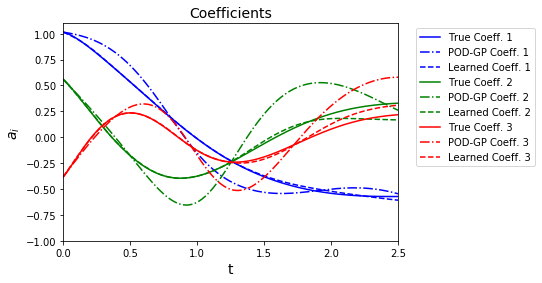

In [24]:
plot_obj = custom_plot(tf.concat([true_ai_red, val_true_ai_red], axis=0), ai_whole, tf.concat([t, val_t], axis=0), args)
plot_obj.plot(pred_zy_whole[:, :, :args.state_dim])

#### Save data for later comparison

In [26]:
os.chdir(basedir)

pred_y_whole = pred_zy_whole[:, :, :args.state_dim]

with open(os.path.join('neuralDDE_ROM_Closure/final_paper_scripts', 'nDistDDE_Exp1.pkl'), 'wb') as output:
    pickle.dump(pred_y_whole, output, pickle.HIGHEST_PROTOCOL)

#### Print the network architecture

In [ ]:
func_main.summary()

In [ ]:
func_aux.summary()